In [17]:
# feature importances
from rfpimp import permutation_importances
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# clustering 1d array
from scipy.signal import argrelextrema
from sklearn.neighbors.kde import KernelDensity

# data processing
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# db operations
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.4f}'.format

In [3]:
def connect():
    conn_args = {'check_same_thread': False}
    engine = create_engine('sqlite:///../recommendation.db', connect_args=conn_args)
    return sessionmaker(bind=engine)()

In [20]:
sql = """
    SELECT
        b.title_id,
        original_title,
        title_type,
        average_rating,
        num_votes,
        start_year,
        end_year,
        runtime,
        genres,
        is_adult
    FROM basics AS b 
        INNER JOIN ratings AS r
            ON b.title_id = r.title_id
"""

In [21]:
session = connect()
raw = pd.read_sql(con=session.bind, sql=sql)
session.close()

#### Intro

In [22]:
df = raw.dropna(subset=['genres', 'runtime'])

In [23]:
df = df.replace('', np.nan)

In [24]:
df.head()

,title_id,original_title,title_type,average_rating,num_votes,start_year,end_year,runtime,genres,is_adult
0,tt0000001,Carmencita,short,5.6000,1611,1894.0000,nan,1.0000,"Documentary,Short",0
1,tt0000002,Le clown et ses chiens,short,6.0000,198,1892.0000,nan,5.0000,"Animation,Short",0
2,tt0000003,Pauvre Pierrot,short,6.5000,1289,1892.0000,nan,4.0000,"Animation,Comedy,Romance",0
3,tt0000004,Un bon bock,short,6.1000,121,1892.0000,nan,12.0000,"Animation,Short",0
4,tt0000005,Blacksmith Scene,short,6.1000,2058,1893.0000,nan,1.0000,"Comedy,Short",0


In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,412195.0000,6.4566,1.3771,1.0000,5.7000,6.6000,7.4000,10.0000
num_votes,412195.0000,2214.8220,25059.1464,5.0000,11.0000,32.0000,165.0000,2230422.0000
start_year,412177.0000,1994.7759,24.6319,1874.0000,1982.0000,2005.0000,2013.0000,2020.0000
end_year,16152.0000,1999.6207,16.8047,1933.0000,1989.0000,2004.0000,2014.0000,2021.0000
runtime,412195.0000,69.3038,103.4028,0.0000,25.0000,79.0000,95.0000,51420.0000
is_adult,412195.0000,0.0089,0.0937,0.0000,0.0000,0.0000,0.0000,1.0000


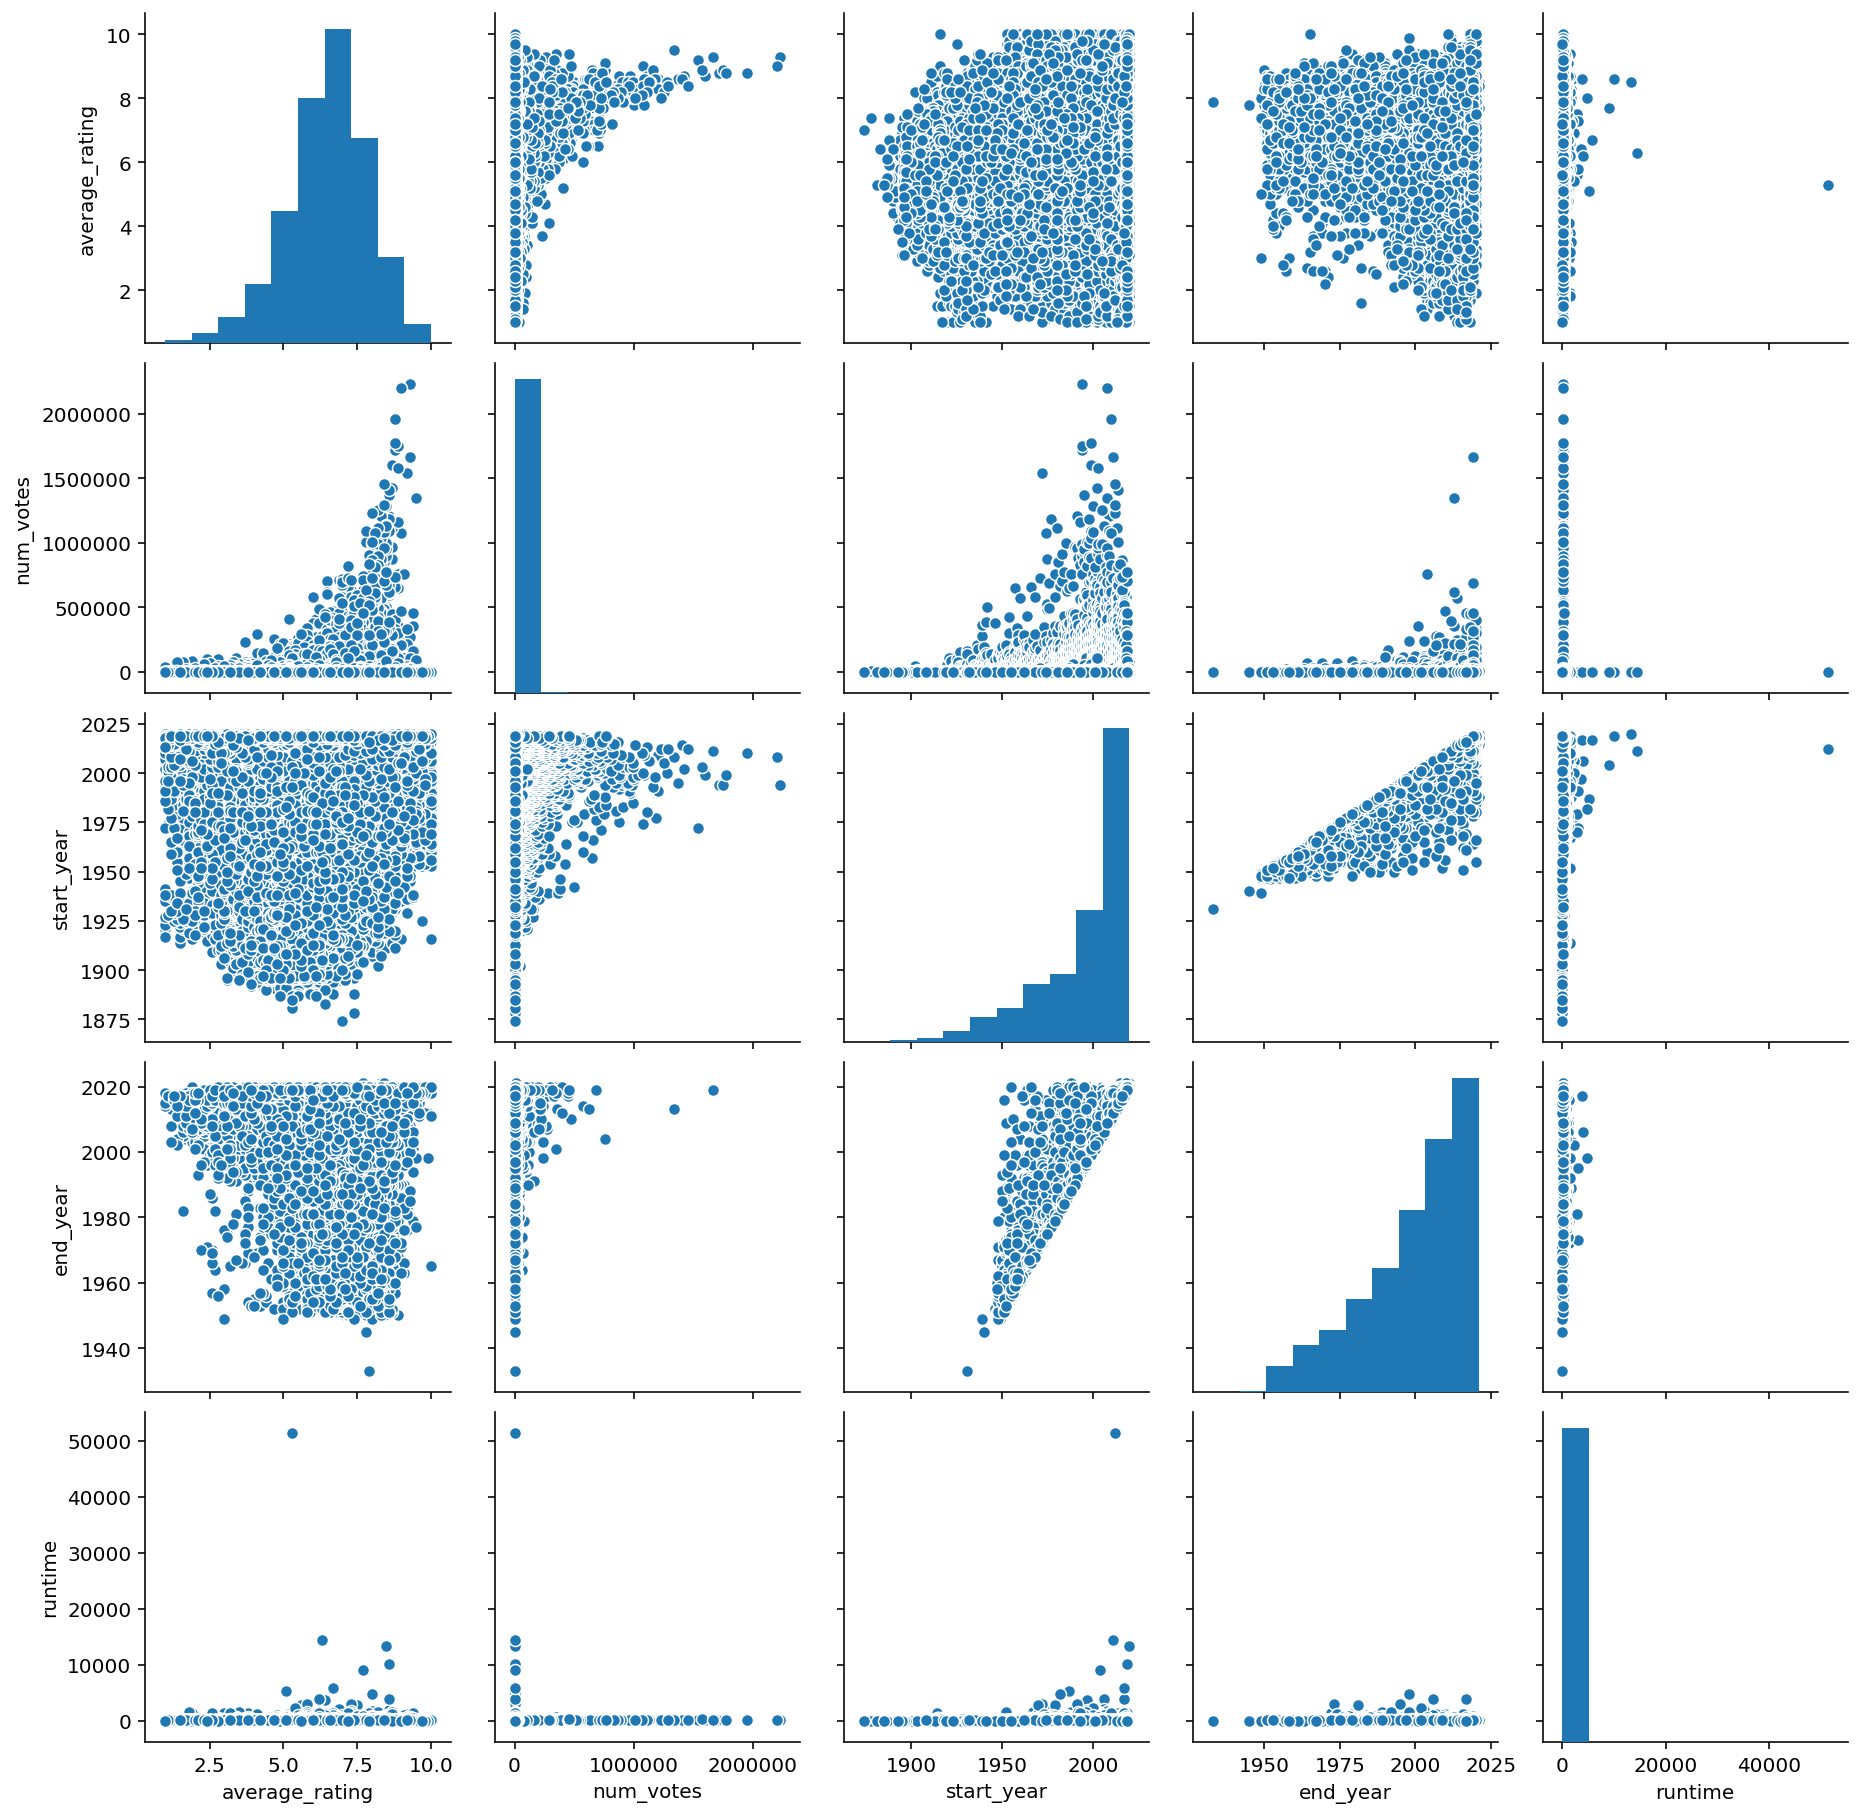

In [26]:
sns.pairplot(df.drop('is_adult', axis=1));

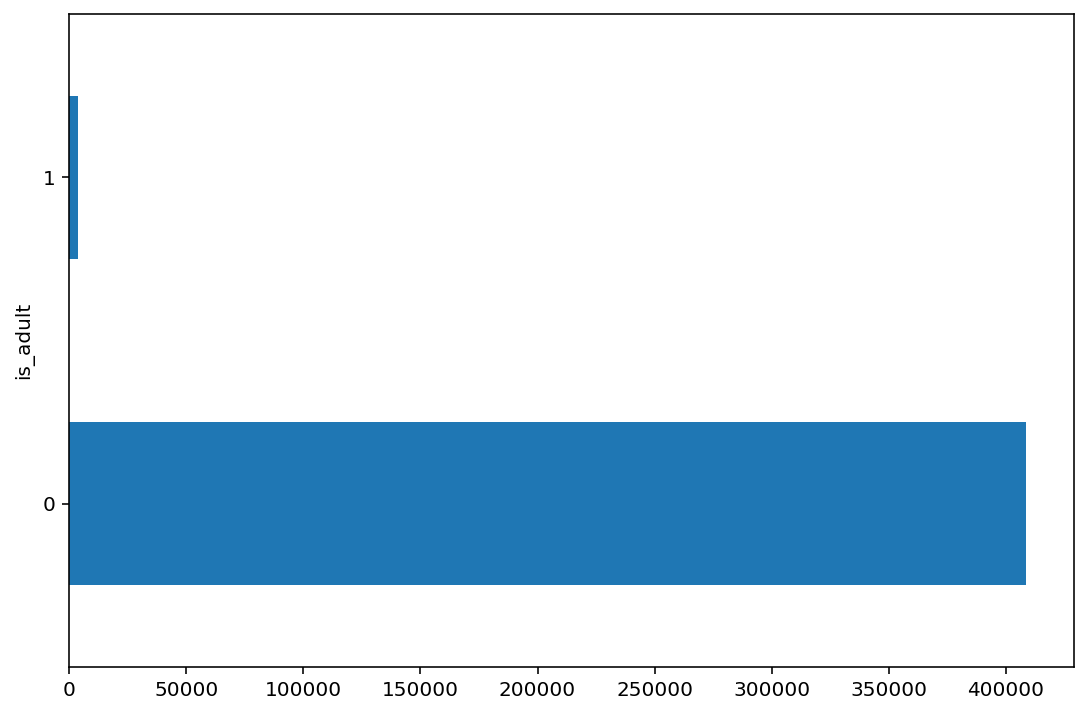

In [27]:
df.groupby('is_adult').size().plot.barh(figsize=(9, 6));

#### Preprocessing

In [28]:
df.isnull().sum()

title_id               0
original_title         0
title_type             0
average_rating         0
num_votes              0
start_year            18
end_year          396043
runtime                0
genres                 0
is_adult               0
dtype: int64

- Delete the `end_year` variable because it contains too many missing values

In [29]:
df = df.drop('end_year', axis=1)

In [30]:
cols = [
    'original_title',
    'title_type',
    'average_rating',
    'num_votes',
    'start_year',
    'runtime',
    'genres',
]

- Convert string to int with label encoder

In [31]:
le = LabelEncoder()
dataset = df[cols].dropna().copy()
dataset['title_type'] = le.fit_transform(dataset['title_type'])

In [32]:
dataset.head()

,original_title,title_type,average_rating,num_votes,start_year,runtime,genres
0,Carmencita,1,5.6000,1611,1894.0000,1.0000,"Documentary,Short"
1,Le clown et ses chiens,1,6.0000,198,1892.0000,5.0000,"Animation,Short"
2,Pauvre Pierrot,1,6.5000,1289,1892.0000,4.0000,"Animation,Comedy,Romance"
3,Un bon bock,1,6.1000,121,1892.0000,12.0000,"Animation,Short"
4,Blacksmith Scene,1,6.1000,2058,1893.0000,1.0000,"Comedy,Short"


#### Feature Importances

In [33]:
def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)
    
    return df

In [34]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

In [35]:
def drop_col_feat_imp(model, X_train, y_train, random_state=42):
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    return imp_df(X_train.columns, importances)

In [36]:
X = dataset.drop(['average_rating', 'original_title', 'genres'], axis=1)
y = dataset['average_rating']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [38]:
rf = RandomForestRegressor().fit(X_train, y_train)

In [39]:
rf.score(X_train, y_train) 

0.6875266773802764

- Features importances by random forests

In [40]:
imp_df(X.columns, rf.feature_importances_)

,Importance
Feature,
num_votes,0.3753
runtime,0.3139
start_year,0.2739
title_type,0.0369


- Feature importances with permutation
- See `references` for detailed information about `permutation_importances`

In [41]:
permutation_importances(rf, X_train, y_train, r2)

,Importance
Feature,
runtime,0.7889
num_votes,0.7666
start_year,0.7548
title_type,0.4050


- Make `feature importances` comparisons by deleting columns one by one

In [42]:
drop_col_feat_imp(rf, X_train, y_train)

,Importance
Feature,
num_votes,0.4821
start_year,0.3710
runtime,0.3502
title_type,0.0541


#### Scoring

In [43]:
dataset['score'] = (
    0.4821 * dataset['num_votes'] + 0.3502 * dataset['runtime'] + 
    0.3710 * dataset['start_year'] + 0.0541 * dataset['title_type']
)

In [44]:
dataset = dataset.reset_index(drop=True)

In [45]:
dataset.sort_values(by='score', ascending=False).head(20)

,original_title,title_type,average_rating,num_votes,start_year,runtime,genres,score
74808,The Shawshank Redemption,0,9.3000,2230422,1994.0000,142.0000,Drama,1076075.9486
183828,The Dark Knight,0,9.0000,2202903,2008.0000,152.0000,"Action,Crime,Drama",1062817.7347
238358,Inception,0,8.8000,1955563,2010.0000,148.0000,"Action,Adventure,Sci-Fi",943574.4619
87694,Fight Club,0,8.8000,1776530,1999.0000,139.0000,Drama,857255.4198
74613,Pulp Fiction,0,8.9000,1748862,1994.0000,154.0000,"Crime,Drama",843920.0750
73854,Forrest Gump,0,8.8000,1720162,1994.0000,142.0000,"Drama,Romance",830079.6026
204889,Game of Thrones,4,9.3000,1667642,2011.0000,57.0000,"Action,Adventure,Drama",804736.4670
86194,The Matrix,0,8.7000,1601813,1999.0000,136.0000,"Action,Sci-Fi",773023.3035
81492,The Lord of the Rings: The Fellowship of the Ring,0,8.8000,1591899,2001.0000,178.0000,"Action,Adventure,Drama",768259.2145
97877,The Lord of the Rings: The Return of the King,0,8.9000,1578932,2003.0000,201.0000,"Adventure,Drama,Fantasy",762016.6204


In [46]:
dataset['score'].describe().T

count    412177.0000
mean       1832.1954
std       12082.8198
min         706.6018
25%         762.3822
50%         784.7995
75%         850.5113
max     1076075.9486
Name: score, dtype: float64

#### Clustering

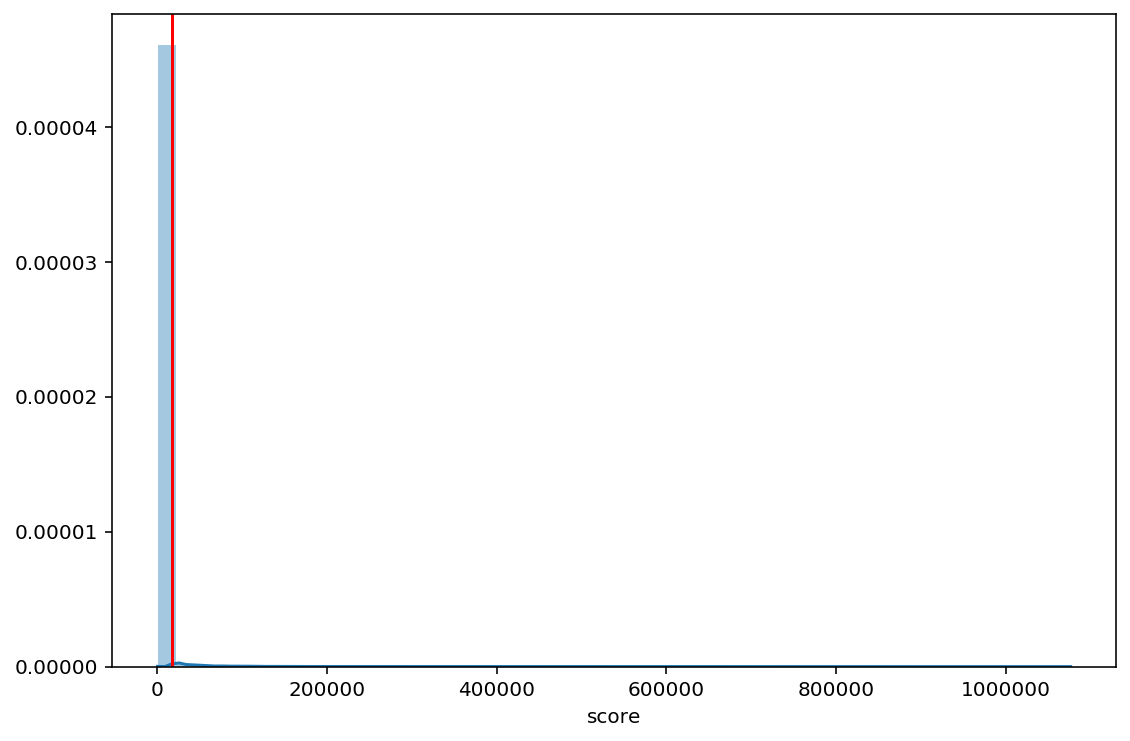

In [49]:
plt.figure(figsize=(9, 6))
sns.distplot(dataset['score'])
plt.axvline(18000, color='r');

- If I don't set the 18,000 limit, it collects all the values up to 18,000 in a cluster
- You can try if you want

In [50]:
vals = dataset['score'].values.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(vals)

s = np.linspace(650, 18000)
e = kde.score_samples(s.reshape(-1,1))

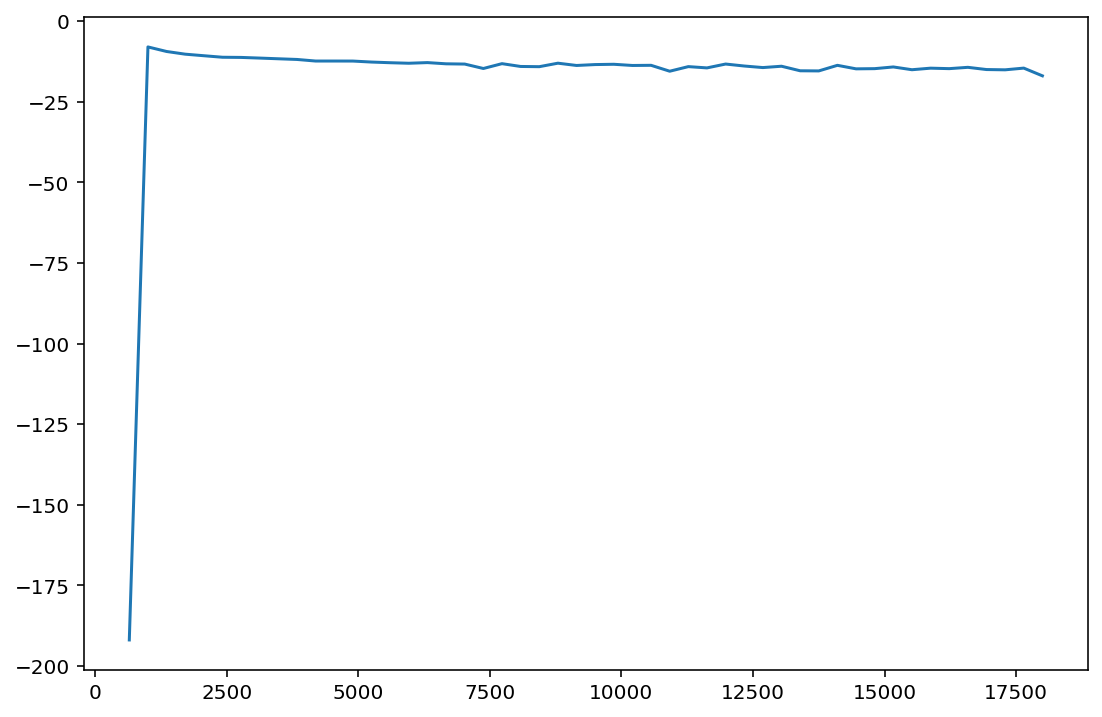

In [51]:
plt.figure(figsize=(9, 6))
plt.plot(s, e);

- Find min-max points of clusters
- Concat min points (`s[mi]`) and max points (`s[ma]`)
- Sort points
- And assign clusters

In [52]:
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

In [53]:
points = np.concatenate((s[mi], s[ma]), axis=0)
buckets = []

for point in points:
    buckets.append(point)

In [54]:
buckets = np.array(buckets)
buckets.sort()

In [55]:
dataset['cluster'] = buckets.searchsorted(dataset.score)

In [56]:
dataset.groupby('cluster').size()

cluster
0     352655
1      47356
2        721
3       1980
4        378
5        926
6        242
7        418
8        204
9        189
10       372
11       161
12       146
13       150
14       136
15       124
16       106
17       205
18       107
19       177
20        83
21        90
22       144
23        90
24        94
25        73
26        73
27       129
28        73
29      4575
dtype: int64

#### Recommendation

- Tf-idf vectorizer for finding similarity of genres
- Linear kernel creates an NxN matrix with similarities between movies

In [57]:
tfidf_vectorizer = TfidfVectorizer()
matrix = tfidf_vectorizer.fit_transform(dataset['genres'])

In [62]:
def get_recommendations(movie_index):
    print(dataset.iloc[movie_index])
    
    kernel = linear_kernel(matrix[movie_index], matrix)
    sim_scores = list(enumerate(kernel[0]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    indexes = [i[0] for i in sim_scores if i[0] != movie_index and i[1] > .5]
    
    cond1 = (dataset.index.isin(indexes))
    cond2 = (dataset.cluster == dataset.iloc[movie_index]['cluster'])
    cond3 = (dataset.title_type == dataset.iloc[movie_index]['title_type'])
    
    selected = dataset.loc[cond1 & cond2 & cond3] \
        .sort_values(by='score', ascending=False).head(20)
    display(selected)

In [65]:
get_recommendations(74808)

original_title    The Shawshank Redemption
title_type                               0
average_rating                      9.3000
num_votes                          2230422
start_year                       1994.0000
runtime                           142.0000
genres                               Drama
score                         1076075.9486
cluster                                 29
Name: 74808, dtype: object


,original_title,title_type,average_rating,num_votes,start_year,runtime,genres,score,cluster
87694,Fight Club,0,8.8000,1776530,1999.0000,139.0000,Drama,857255.4198,29
98770,American Beauty,0,8.3000,1034338,1999.0000,122.0000,Drama,499438.7032,29
81386,American History X,0,8.5000,998724,1998.0000,119.0000,Drama,482267.7722,29
46176,One Flew Over the Cuckoo's Nest,0,8.7000,876317,1975.0000,133.0000,Drama,423251.7273,29
102532,Requiem for a Dream,0,8.3000,736045,2000.0000,102.0000,Drama,355625.0149,29
226122,Gran Torino,0,8.1000,697458,2008.0000,116.0000,Drama,337030.0930,29
79475,Trainspotting,0,8.1000,615025,1996.0000,93.0000,Drama,297276.6371,29
303157,Birdman or (The Unexpected Virtue of Ignorance),0,7.7000,554989,2014.0000,119.0000,"Comedy,Drama",268349.0647,29
184060,There Will Be Blood,0,8.2000,491736,2007.0000,158.0000,Drama,237865.8542,29
183630,Juno,0,7.4000,479028,2007.0000,96.0000,"Comedy,Drama",231717.6150,29


In [68]:
get_recommendations(73058)

original_title           Friends
title_type                     4
average_rating            8.9000
num_votes                 757071
start_year             1994.0000
runtime                  22.0000
genres            Comedy,Romance
score                365731.6239
cluster                       29
Name: 73058, dtype: object


,original_title,title_type,average_rating,num_votes,start_year,runtime,genres,score,cluster
202686,The Big Bang Theory,4,8.1000,686500,2007.0000,22.0000,"Comedy,Romance",331714.1678,29
182035,How I Met Your Mother,4,8.3000,571896,2005.0000,22.0000,"Comedy,Romance",276462.8374,29
163589,The Office,4,8.9000,353501,2005.0000,22.0000,Comedy,171174.6079,29
243192,Modern Family,4,8.4000,327572,2009.0000,22.0000,"Comedy,Drama,Romance",158675.7210,29
158055,Arrested Development,4,8.7000,266660,2003.0000,22.0000,Comedy,129307.8198,29
65939,Seinfeld,4,8.8000,240628,1989.0000,22.0000,Comedy,116752.5986,29
158680,Two and a Half Men,4,7.0000,233805,2003.0000,22.0000,"Comedy,Romance",113468.4243,29
169959,Grey's Anatomy,4,7.6000,232516,2005.0000,41.0000,"Drama,Romance",112854.3932,29
229892,Parks and Recreation,4,8.6000,194646,2009.0000,22.0000,Comedy,94592.0964,29
242962,Community,4,8.5000,189258,2009.0000,22.0000,Comedy,91994.5416,29


#### References
- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
- https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html